In [ ]:
%uv  pip install -U bitsandbytes
%uv pip install transformers
%uv pip install peft
%uv pip install accelerate
%uv pip install datasets
%uv pip install accelerate
%uv pip install groq
%uv pip install -U bitsandbytes
%uv pip install matplotlib


In [3]:
import os
os.mkdir("tinyllama_v1")
os.mkdir("tinyllama_v2")
os.mkdir("tinyllama_v3")
os.mkdir("data")
os.mkdir("src")

In [4]:
from src.data_generator import DomainDatasetGenerator
from src.fine_tuning import DomainNameTrainer
from src.llm_evaluator import LLMJudgeEvaluator
from src.safety_filter import SafetyFilter
from src.testing import TestFramework
from src.domain_generator import DomainNameGenerator
import re


### 1. Generate dataset

In [6]:
# initialize generator object
generator = DomainDatasetGenerator()

# create first synthetic dataset with 100 samples
dataset_v1 = generator.generate_dataset(size=100)

# create second synthetic dataset with 500 samples
dataset_v2 = generator.generate_dataset(size=500)
generator.save_dataset(dataset_v1, "./data/domain_dataset_v1.jsonl")
generator.save_dataset(dataset_v2, "./data/domain_dataset_v2.jsonl")


### 2. Lora fine tuning

##### Model 1 fine-tuned with dataset 1

In [2]:
# initialize with TinyLlama-1.1B-Chat-v1.0 as base model
trainer = DomainNameTrainer("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

results = trainer.train(
        data_path="./data/domain_dataset_v1.jsonl",
        output_dir="tinyllama_v1"
    )



Setting up tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading and preprocessing data...


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Setting up model...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Trainable parameters of the model:
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044
Setting up trainer...
Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jithinrajr98 (jithinrajr98-chanel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


Saving model...
Training completed!


##### Model 2 fine-tuned with dataset 2

In [3]:
results = trainer.train(
        data_path="./data/domain_dataset_v2.jsonl",
        output_dir="tinyllama_v2"
    )

Setting up tokenizer...
Loading and preprocessing data...


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Setting up model...
Trainable parameters of the model:
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044
Setting up trainer...
Starting training...


Step,Training Loss
10,3.113000
20,0.143300


Step,Training Loss
10,3.113000
20,0.143300
30,0.112300


Saving model...
Training completed!


##### Model 3 fine-tuned with llm generated data

In [6]:
trainer = DomainNameTrainer("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
results = trainer.train(
        data_path="./data/domain_dataset_v3.jsonl",
        output_dir="tinyllama_v3"
    )

Setting up tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading and preprocessing data...


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

Setting up model...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Trainable parameters of the model:
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044
Setting up trainer...
Starting training...


Step,Training Loss
10,3.087800
20,0.136500


Saving model...
Training completed!


### 3. Model Evaluation using LLM as evaluator

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


# Usage example
def run_test(modelname:str):
    # Initialize your components
    generator = DomainNameGenerator("TinyLlama/TinyLlama-1.1B-Chat-v1.0", modelname)
    safety_filter = SafetyFilter()
    judge = LLMJudgeEvaluator()  # Use your LLM judge class

    # Run test
    tester = TestFramework(generator, safety_filter, judge)
    results = tester.run_test()
    # Print summaries
    tester.print_summary()
    tester.print_detailed_results()

    return results




# Load the dataframe.
def create_plot(df):

    # Calculate the average llm_score for each category.
    avg_score_by_category = df.groupby('category')['llm_score'].mean().reset_index()

    # Sort the data by the average score for better visualization.
    avg_score_by_category = avg_score_by_category.sort_values(by='llm_score', ascending=False)

    # Create a bar graph.
    plt.figure(figsize=(10, 6))
    plt.bar(avg_score_by_category['category'], avg_score_by_category['llm_score'], color='skyblue')

    # Add labels and a title.
    plt.title('Average LLM Score by Category')
    plt.xlabel('Category')
    plt.ylabel('Average LLM Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the plot to a file.
    plt.savefig('average_llm_score_by_category.png')

##### Evaluation of Model 1

Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Model loaded!
Running test suite...
Testing: organic coffee shop in downtow...
Top 3 domains: ["'organic-coffee-shop.com'", "'organic-coffee-shop.com'", "'downtown-coffee.com'"]
Testing: tech startup building mobile a...
Top 3 domains: ["```\n        ['tech-startup.com'", "'mobile-app-builder.com']", '"techstartup.net"']
Testing: family restaurant serving Ital...
Top 3 domains: ['```\n        [\n            {\n                "domain": "italian-family-restaurant.com"\n            }', '', '{\n                "domain": "italianfamilyrestaurant.com"\n            }\n        ]']
Testing: fitness gym with personal trai...
Top 3 domains: ['"fitnessgym-training.com"', "'fittest.com'", '```\n        ["fitnessgym-training.com"']
Testing: bakery
Top 3 domains: ['', '[', '']
Testing: law firm
Top 3 domains: ['company: law-firm.com', '```\n        ["law-firm-co.com"]', '#Domain Name: lawfirm.com']
Testing: a comprehensive digital market...
Top 3 domains: ['"comprehensive.co"', '"digitalmarketing.co

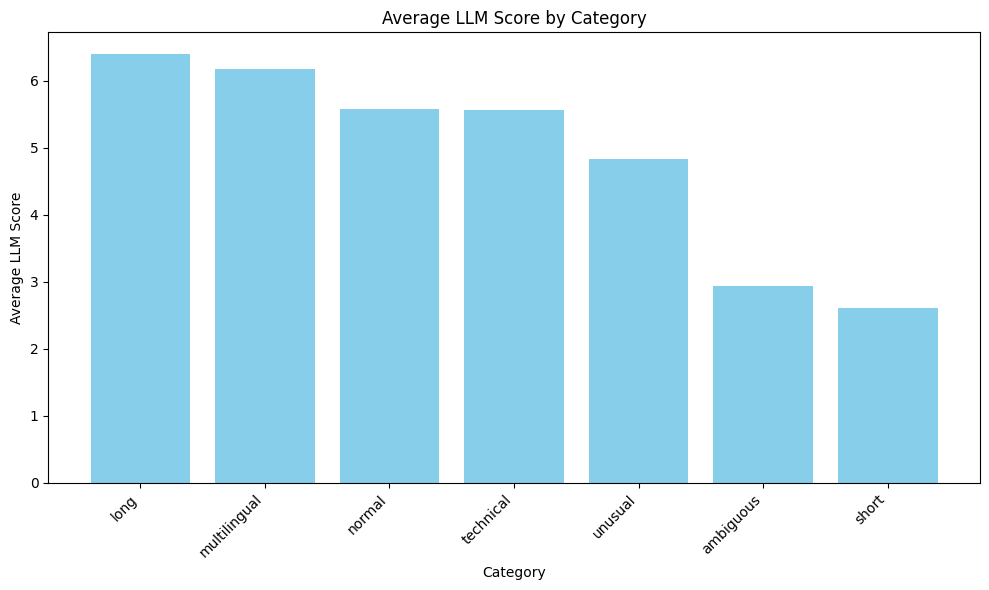

In [5]:
result_1 = run_test("tinyllama_v1")
result_1.to_csv("evaluation_result_1.csv",index=False)

create_plot(result_1)

##### Evaluation of Model 2

Loading model...
Model loaded!
Running test suite...
Testing: organic coffee shop in downtow...
Top 3 domains: ['shop-co.io', 'shoporganic.co', 'localcoffee.co']
Testing: tech startup building mobile a...
Top 3 domains: ['tech-taking-startup.org', 'apps.build-tech-startup.net', 'apps-technology.org']
Testing: family restaurant serving Ital...
Top 3 domains: ['italian-cuisine.io', 'family-restaurant.com', 'restaurant-serving.net']
Testing: fitness gym with personal trai...
Top 3 domains: ['fitness-gym.io', '01-personal-fitness.com', 'gym-firm.com']
Testing: bakery
Top 3 domains: ['bakery-bakery.co', 'bakery-api.org', 'bakery-api.io']
Testing: law firm
Top 3 domains: ['law-ltd.com', 'law-lawyer.net', 'law-co.io']
Testing: a comprehensive digital market...
Top 3 domains: ['agency.io', 'digital-agency.io', 'digital-agency.io']
Testing: quantum computing research lab...
Top 3 domains: ['quantum-laboratory.com', 'quantum-laboratory.com', 'qlrl.org']
Testing: blockchain cryptocurrency exch...

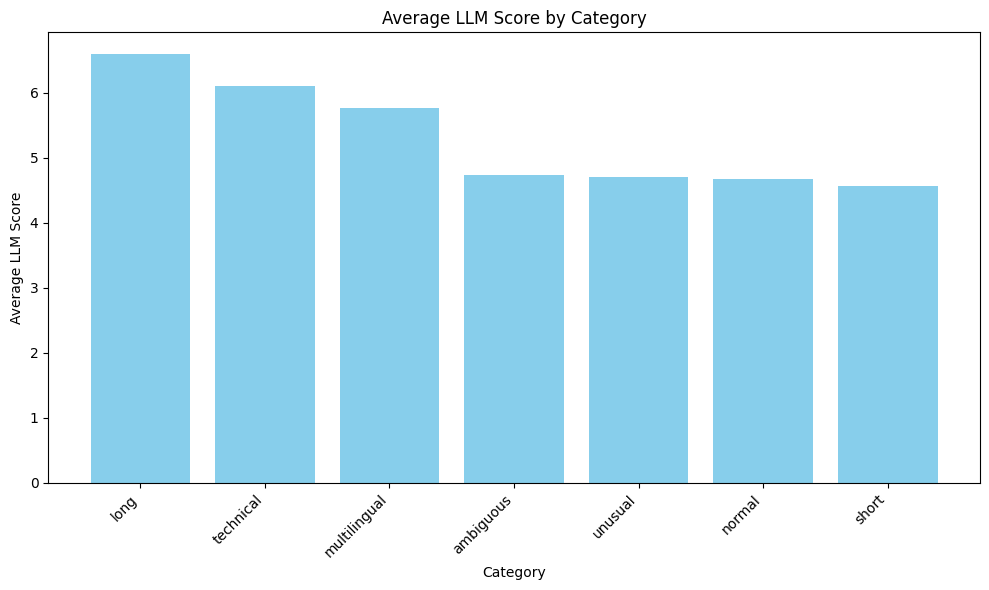

In [6]:
result_2 = run_test("tinyllama_v2")
result_2.to_csv("evaluation_result_2.csv",index=False)

create_plot(result_2)

##### Evaluation of Model 3

Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Model loaded!
Running test suite...
Testing: organic coffee shop in downtow...
Top 3 domains: ['downtowncoffee.net', 'roasters.co', 'rosegold.co']
Testing: tech startup building mobile a...
Top 3 domains: ['mobile-dev.net', 'appstore.co', 'appgenius.net']
Testing: family restaurant serving Ital...
Top 3 domains: ['italian-restaurant.com', 'family-restaurant.co', 'italian-gourmet.net']
Testing: fitness gym with personal trai...
Top 3 domains: ['fitness-gym.co', 'personal.co', 'personal.gym']
Testing: bakery
Top 3 domains: ['bakery.co', 'bakery.io', 'bakery.info']
Testing: law firm
Top 3 domains: ['#lawfirm.io\n        #lawyer.co', '#lawfirm.io', 'legalservices.co']
Testing: a comprehensive digital market...
Top 3 domains: ['socialmarketing.co', 'custombranding.io', 'searchmarketing.org']
Testing: quantum computing research lab...
Top 3 domains: ['quantum-labs.cc', 'quantum-instruments.net', 'quantumcomputing.io']
Testing: blockchain cryptocurrency exch...
Top 3 domains: ['blockchain-exc

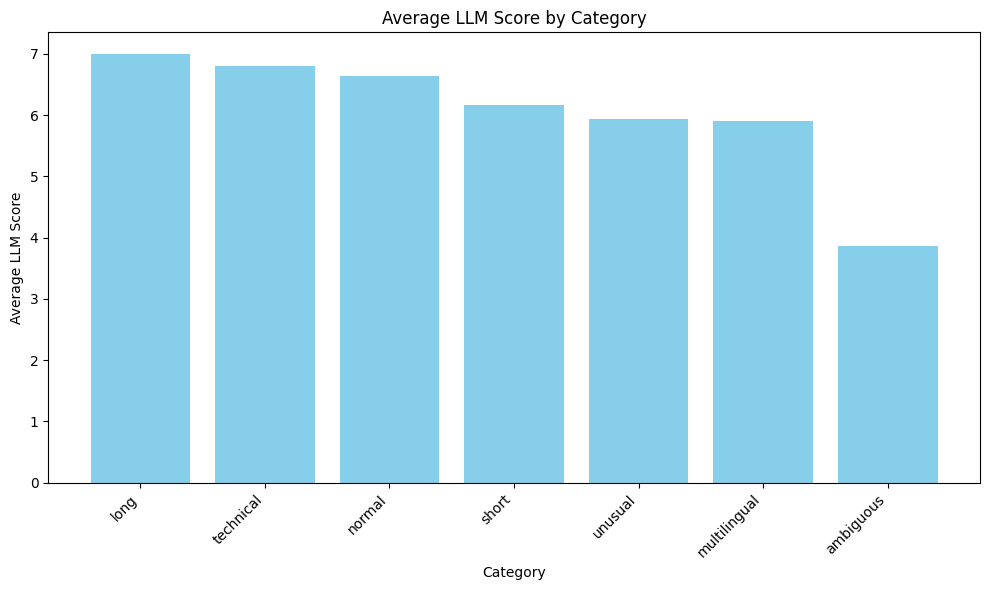

In [8]:
result_3 = run_test("tinyllama_v3")
result_3.to_csv("evaluation_result_3.csv",index=False)

create_plot(result_3)

#### Generate response with the best model

In [32]:

def domain_recommendation(desc: str, generator: DomainNameGenerator):

    safety_filter = SafetyFilter()


    safety_result = safety_filter.is_safe(desc)
                
    if not safety_result['is_safe']:
        result = {
                        'description': desc,
                        'status': 'blocked',
                        'reason': safety_result['reason'],
                        'score': 0
                    }
    else:
        result  = generator.generate_domains(desc)

    return result

In [35]:
desc = "AI Tech startup for financial data based in paris"

generator = DomainNameGenerator("TinyLlama/TinyLlama-1.1B-Chat-v1.0", "tinyllama_v3")

response = domain_recommendation(desc,generator)

print(response)

Loading model...
Model loaded!
[('french-data.net', 0.329), ('financialdata.org', 0.3), ('paristech.fr', 0.3)]
